In [1]:
%matplotlib inline

## Installation



!pip install -U scikit-image(Linux and OSX)

!pip install scikit-image(Windows)

#### For Conda-based distributions

!conda install scikit-image

## Overview of Images in Python

### Importing a GrayScale Image from the skimage library

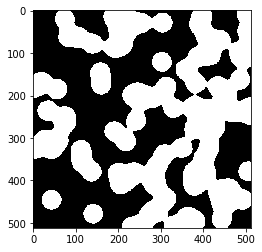

In [2]:
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
image = data.binary_blobs()
plt.imshow(image, cmap='gray')

### Importing a Colored Image from the skimage library

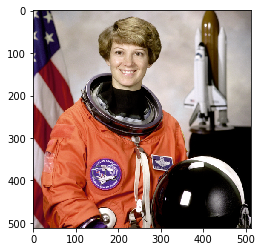

In [14]:
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
image = data.astronaut()
plt.imshow(image)

### Importing an image from an external source


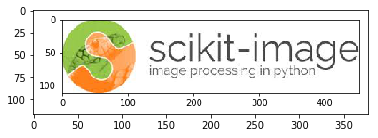

In [57]:
# The I/O module is used for importing the image
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
image = io.imread('scikit_logo.png')
plt.imshow(image)

### Loading multiple images

In [58]:
images = io.ImageCollection('../images/*.png:../images/*.jpg')
print('Type:', type(images))


Type: <class 'skimage.io.collection.ImageCollection'>


### Saving images

In [59]:
#Saving file as 'logo.png'
io.imsave('logo.png',image)

## Image segmentation

## Thresholding
It is the simplest way to segment objects from a background by choosing pixels above or below a certain threshold. This is generally helpful when we intend to segment objects from their background. You can read more about thresholding here.
Let's try this on an image of a textbook which comes preloaded with the scikit-image dataset.

### Basic Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color


A simple function to view the images

In [5]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

### Image

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e3cec4ddd8>)

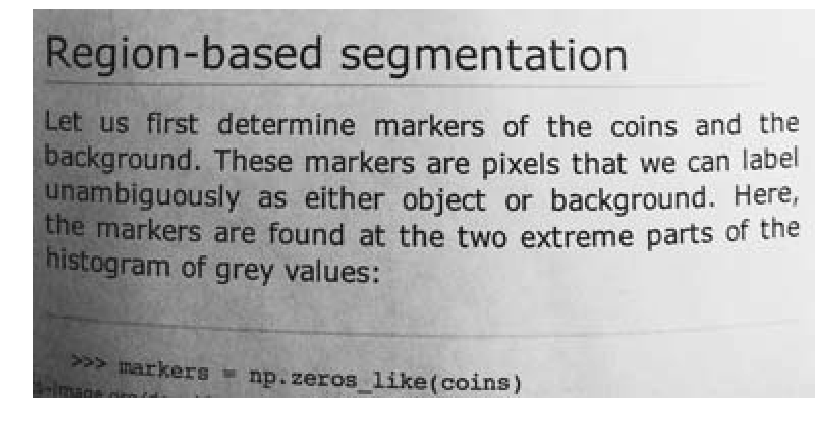

In [6]:
text = data.page()
image_show(text)

### Histograms

A histogram is a graph showing the number of pixels in an image at different intensity values found in that image. Simply put, a histogram is a graph wherein the x-axis shows all the values that are in the image while the y-axis shows the frequency of those values.v

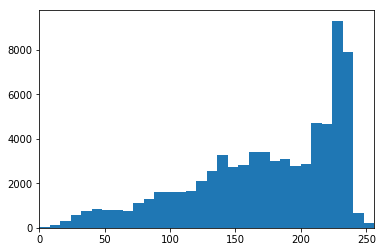

In [7]:
fig, ax = plt.subplots(1, 1)
ax.hist(text.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256);

### Supervised thresholding

Trying simple NumPy methods and a few different thresholds on this image.  Because *we* are setting the threshold, this is *supervised* segmentation.

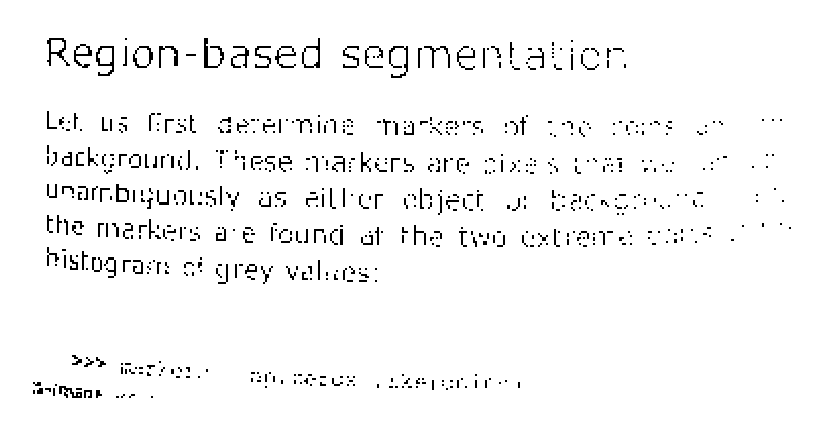

In [8]:
text_segmented = text>50


image_show(text_segmented);

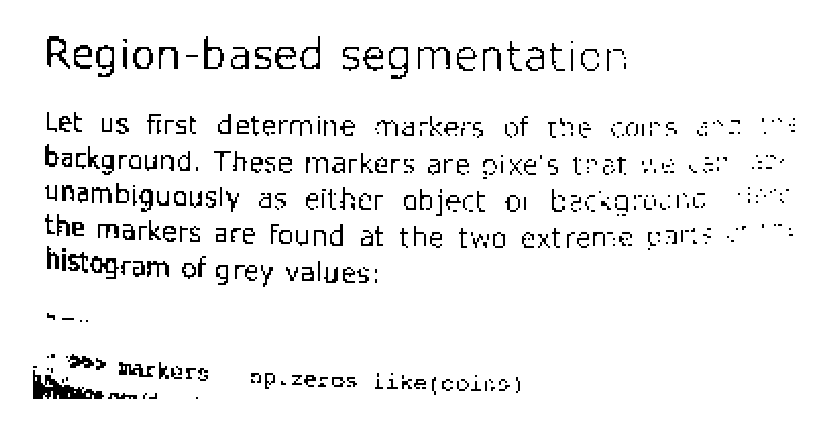

In [90]:
text_segmented = text>70


image_show(text_segmented);

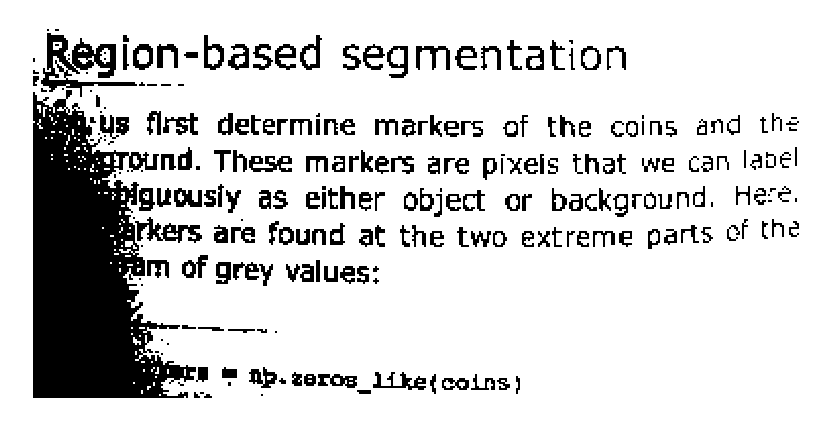

In [9]:
text_segmented = text>120


image_show(text_segmented);

We didn't get any ideal results since the shadow on the left creates problems. Let's try with unsupervised thresholding now.

### Unsupervised thresholding

Scikit-image has a number of automatic thresholding methods, which require no input in choosing an optimal threshold. Some of the methods are : `otsu`, `li`, `local`.

### otsu

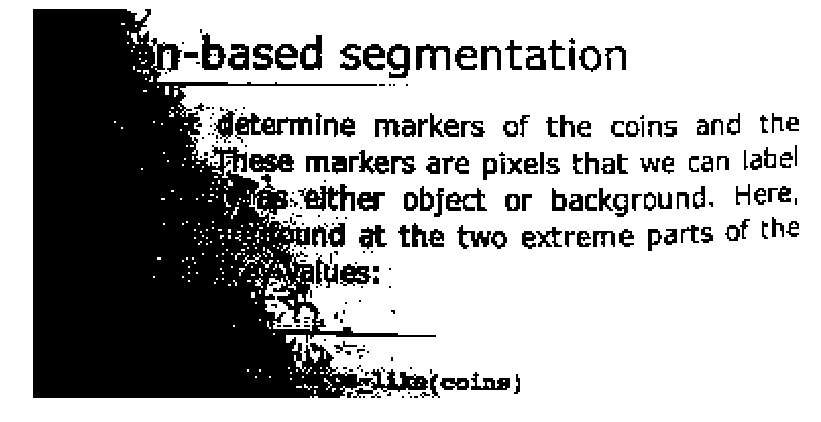

In [10]:
text_threshold = filters.threshold_otsu(text)  # Hit tab with the cursor after the underscore, try several methods

image_show(text > text_threshold);

### li

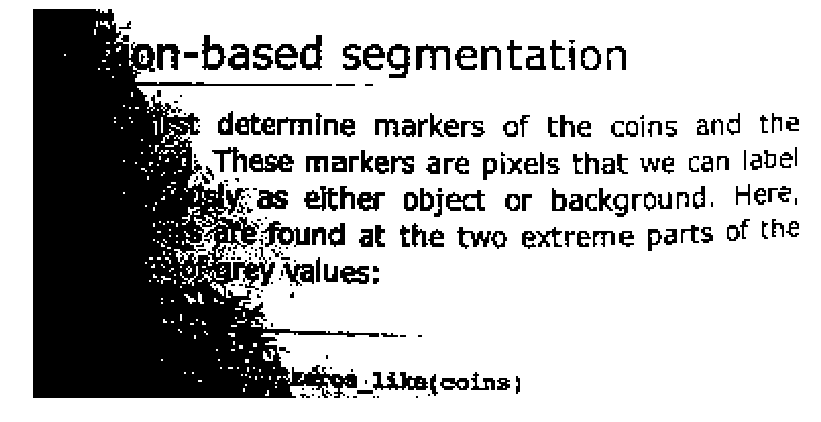

In [11]:
text_threshold = filters.threshold_li(text)  # Hit tab with the cursor after the underscore, try several methods

image_show(text > text_threshold);

### local
In the case of local, we also need to specify the block_size . Offset helps to tune the image for better results.

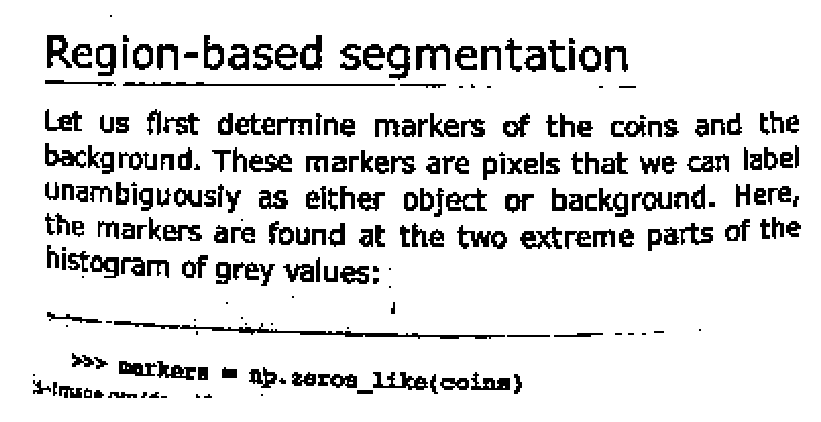

In [12]:
text_threshold = filters.threshold_local(text,block_size=51, offset=10) 
image_show(text > text_threshold);

This is pretty good and has got rid of the noisy regions to a large extent.

## Supervised segmentation

Thresholding is a very basic segmentation process and will not work properly in a high-contrast image for which we will be needing more advanced tools.
For this section, we will use an example image which is freely available and attempt to segment the head portion using supervised segmentation techniques.## Supervised segmentation

For this section, we will use an example image of a girl, which is freely available and attempt to segment the head portion using supervised segmentation techniques.

In [13]:
# import the image
from skimage import io
image = io.imread('girl.jpg') 
plt.imshow(image);

FileNotFoundError: [Errno 2] No such file or directory: 'girl.jpg'

Next step would be to convert the image to grayscale with rgb2gray.

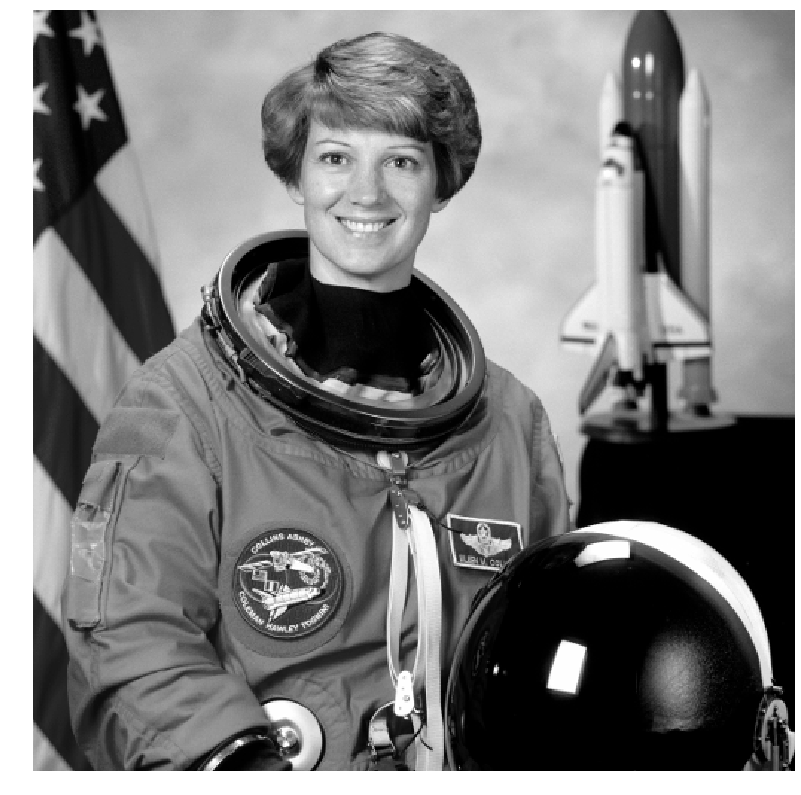

In [15]:
image_gray = color.rgb2gray(image) 
image_show(image_gray);

We will use two segmentation methods which work on entirely different principles.

### Active contour segmentation

Active Contour segmentation also called as snakes and is initialized using a user-defined contour or line, around the area of interest and this contour then slowly contracts and is attracted or repelled from light and edges.
For our example image, let's draw a circle around the person's head to initialize the snake.

In [16]:
def circle_points(resolution, center, radius):
    """
    Generate points defining a circle on an image.
    """
    radians = np.linspace(0, 2*np.pi, resolution)

    c = center[1] + radius*np.cos(radians)
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T

# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [80, 250], 80)[:-1]

The above calculations calculate x and y co-ordinates of the points on the periphery of the circle. Since we have given the resolution to be 200, it will calculate 200 such points.

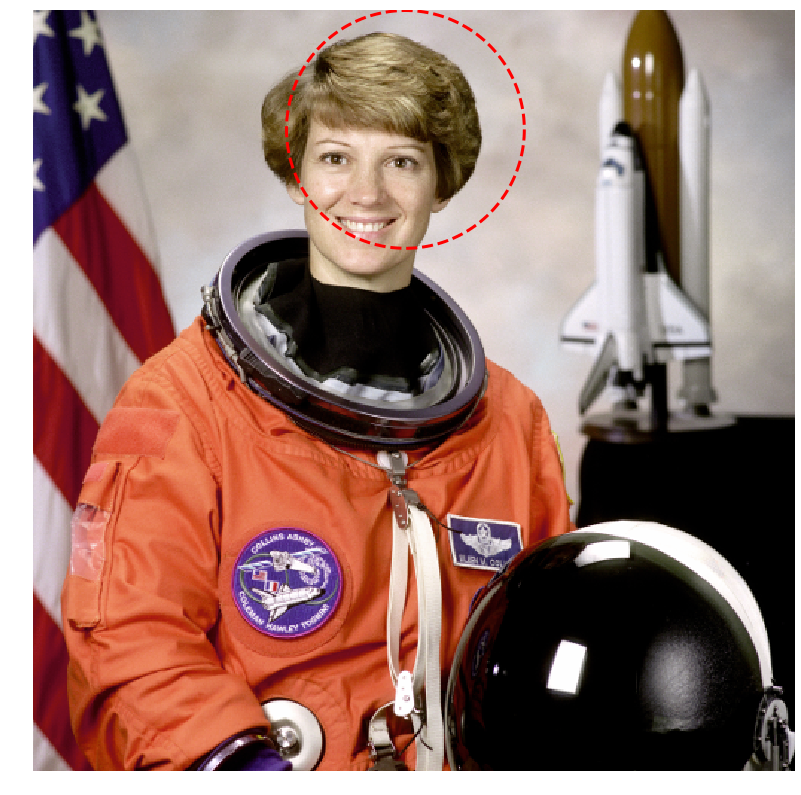

In [17]:
fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

The algorithm then segments the face of a person from the rest of an image by fitting a closed curve to the edges of the face.

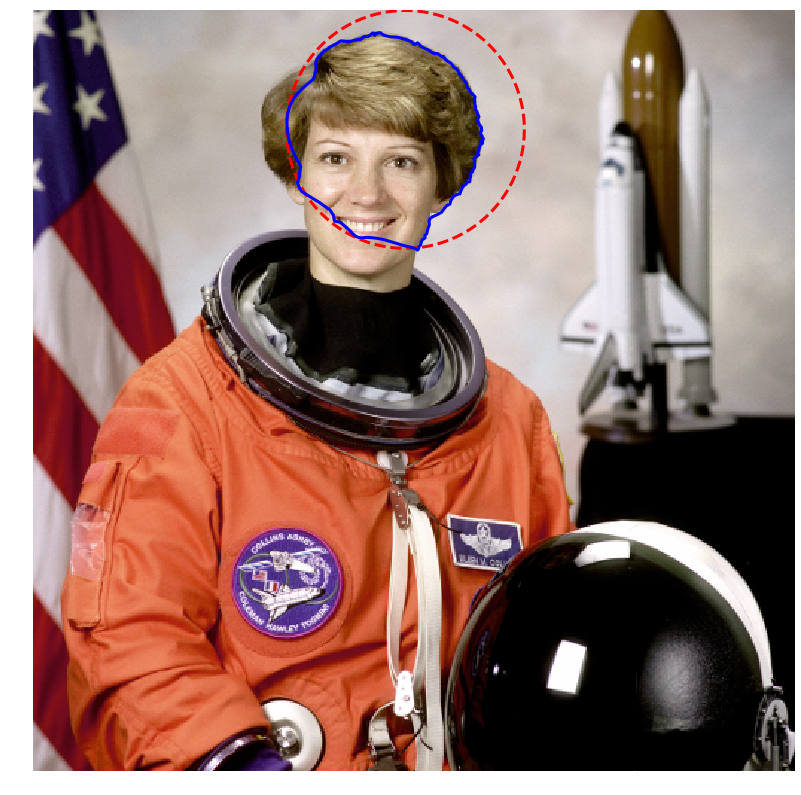

In [18]:
snake = seg.active_contour(image_gray, points)
fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

We can tweak the parameters called alpha and beta. Higher values of alpha will make this snake contract faster while beta makes the snake smoother.

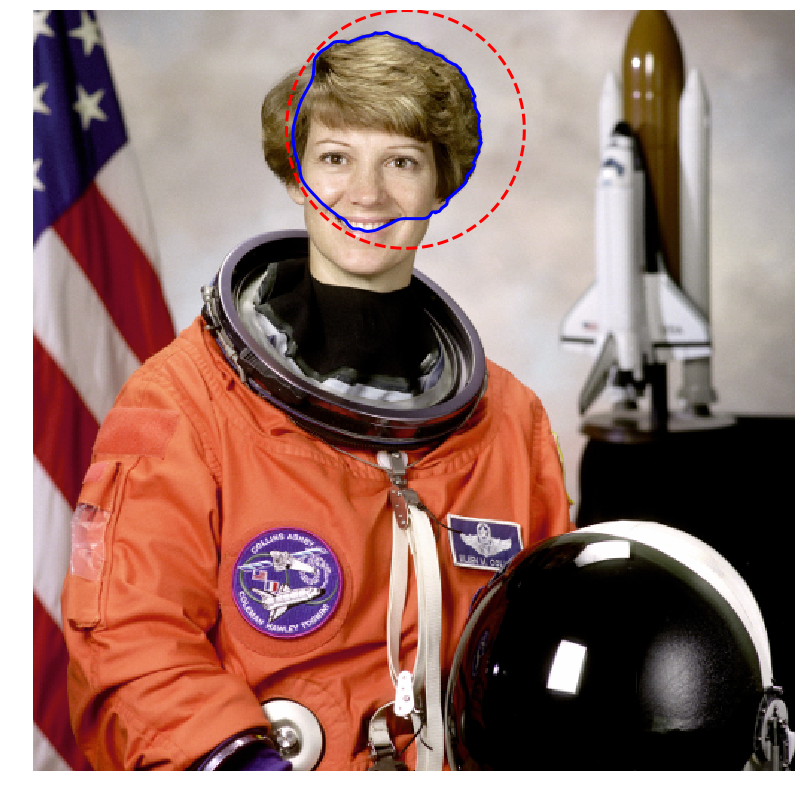

In [19]:
snake = seg.active_contour(image_gray, points,alpha=0.06,beta=0.3)
fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

### Random walker

In this method, a user interactively labels a small number of pixels which are known as labels. Each unlabeled pixel is then imagined to release a random walker and one can then determine the probability of a random walker starting at each unlabeled pixel and reaching one of the prelabeled pixels. By assigning each pixel to the label for which the greatest probability is calculated, high-quality image segmentation may be obtained. Read the Reference paper here.

We will re-use the seed values from our previous example here. We could have
done different initializations but for simplicity let's stick to circles.


In [76]:
image_labels = np.zeros(image_gray.shape, dtype=np.uint8)

The random walker algorithm expects a label image as input. So we will have the bigger circle that encompasses the person's entire face and another smaller circle near the middle of the face.

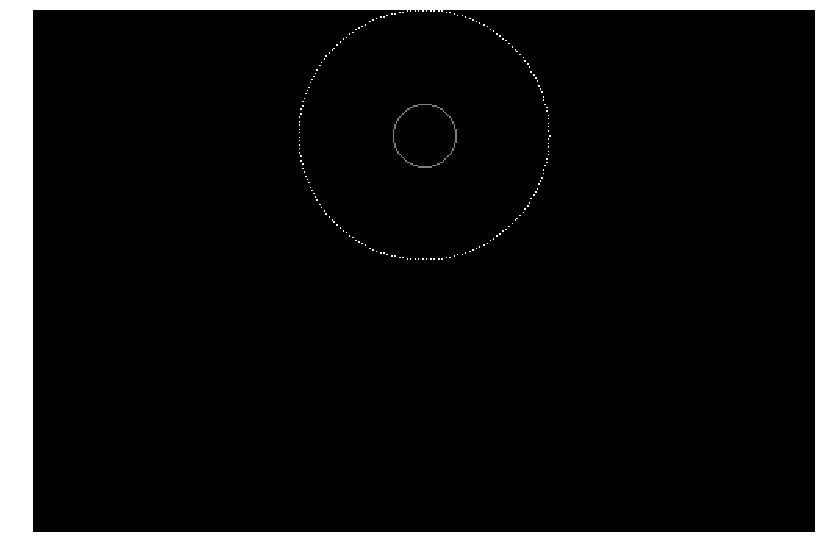

In [77]:
indices = draw.circle_perimeter(80, 250,20)#from here
image_labels[indices] = 1
image_labels[points[:, 1].astype(np.int), points[:, 0].astype(np.int)] = 2
image_show(image_labels);

Now, let's use Random Walker and see what happens.

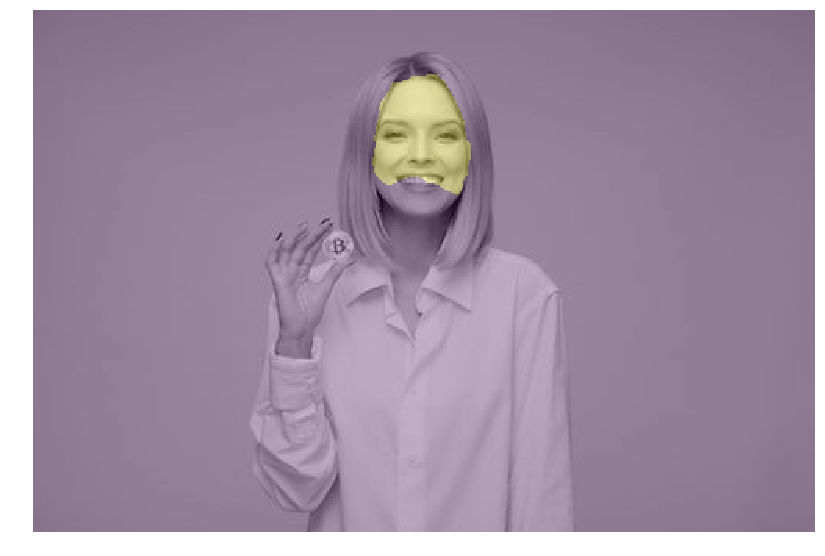

In [78]:
image_segmented = seg.random_walker(image_gray, image_labels)
# Check our results
fig, ax = image_show(image_gray)
ax.imshow(image_segmented == 1, alpha=0.3);

It doesn't look like it's grabbing edges as we wanted. To resolve this situation we can tune in the beta parameter until we get the desired results. After several attempts, a value of 3000 works reasonably well.

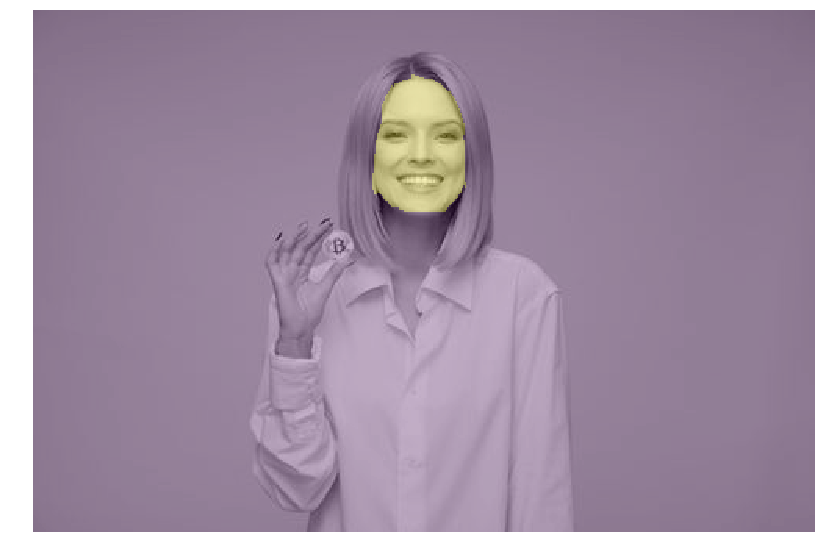

In [79]:
image_segmented = seg.random_walker(image_gray, image_labels, beta = 3000)
# Check our results
fig, ax = image_show(image_gray)
ax.imshow(image_segmented == 1, alpha=0.3);

## Unsupervised segmentation

Unsupervised segmentation requires no prior knowledge. Consider an image that is so large that it is not feasible to consider all pixels simultaneously. So in such cases, Unsupervised segmentation can breakdown the image into several sub-regions, so instead of millions of pixels, you have tens to hundreds of regions. Let's look at two such algorithms:

### SLIC( Simple Linear Iterative Clustering)

SLIC algorithm actually uses a machine learning algorithm called K-Means under the hood. It takes in all the pixel values of the image and tries to separate them out into the given number of sub-regions. Read the Reference Paper here.
SLIC works in color so we will use the original image.

In [80]:
image_slic = seg.slic(image,n_segments=155)

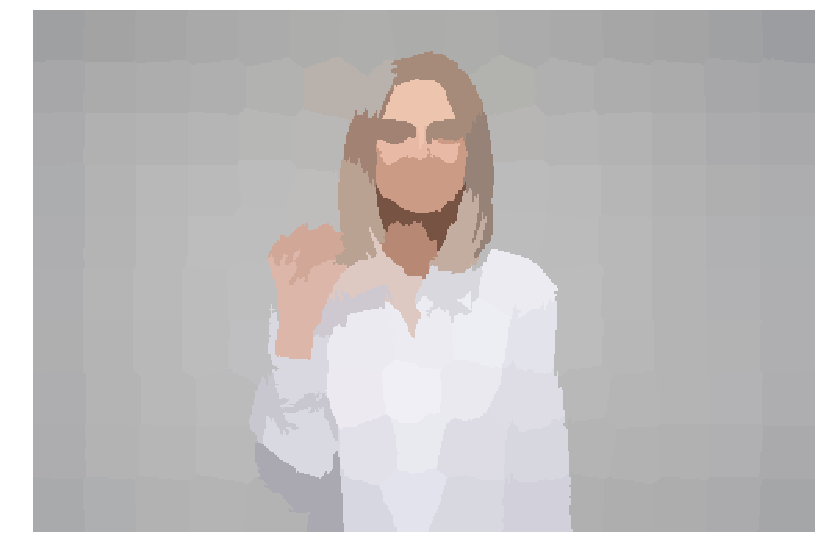

In [81]:
# label2rgb replaces each discrete label with the average interior color
image_show(color.label2rgb(image_slic, image, kind='avg'));

We've reduced this image from 512*512 = 262,000 pixels down to 155 regions.

### Felzenszwalb

This algorithm also uses a machine learning algorithm called minimum-spanning tree clustering under the hood. Felzenszwaib doesn't tell us the exact number of clusters that the image will be partitioned into. It's going to run and generate as many clusters as it thinks is appropriate for that
given scale or zoom factor on the image. The Reference Paper can be accessed here.

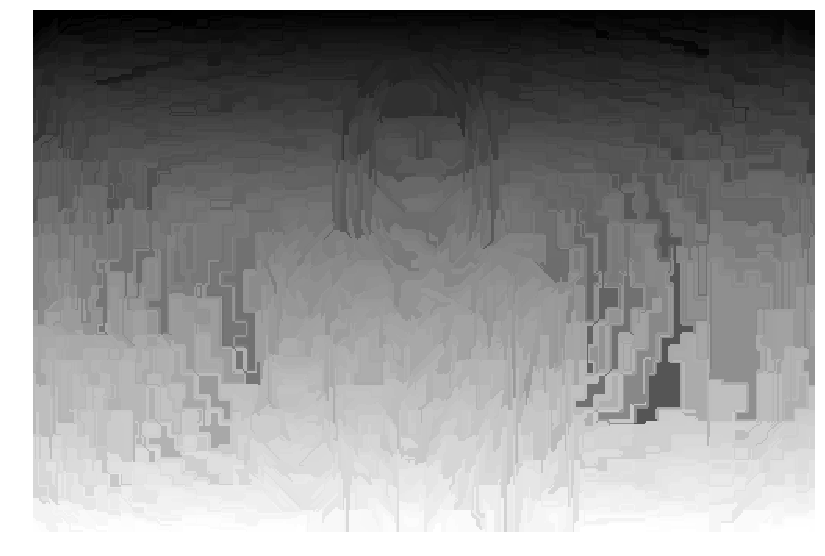

In [82]:
image_felzenszwalb = seg.felzenszwalb(image) 
image_show(image_felzenszwalb);

These are a lot of regions. Let's calculate the number of unique regions.

In [84]:
np.unique(image_felzenszwalb).size


2440

Now let's recolour them using the region average just as we did in the SLIC algorithm.

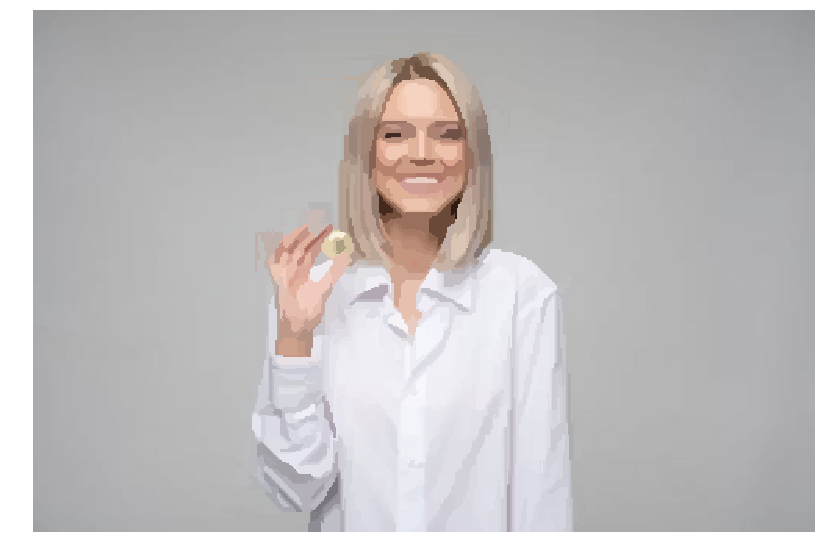

In [85]:
image_felzenszwalb_colored = color.label2rgb(image_felzenszwalb, image, kind='avg')
image_show(image_felzenszwalb_colored);

Now we get reasonable smaller regions. If we wanted still fewer regions, we could change the scale parameter or start here and combine them. This approach is sometimes called **over-segmentation**.

This almost looks more like a posterized image which is essentially just a reduction in the number of colours. To combine them again, you can use the Region Adjacency Graph(RAG)